# Анализ защищенности систем искусственного интеллекта
# Практикческая работа №8
## Методы защиты от атак на модели ИИ
## Выполнил студент группы ББМО-02-23
## Макаров Михаил Максимович

## Цель задания:
Изучить методы защиты моделей ИИ от различных атак, включая методы защиты на уровне данных,
моделирования и обучения. Реализовать эти методы и проверить их эффективность против атак,
изученных ранее.


### Шаг 1. Защита с помощью Adversarial Training

Adversarial Training — это подход к повышению устойчивости моделей, при котором обучение проводится с использованием противоречивых примеров. В процессе обучения модель "знакомится" с такими примерами, что позволяет ей лучше распознавать и противостоять атакам, делая её более устойчивой к потенциальным угрозам.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist

# Загрузка данных MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Нормализация данных: приведение значений пикселей к диапазону [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Преобразование меток в one-hot encoding (каждая метка становится вектором из 10 элементов)
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# Функция FGSM атаки
def fgsm_attack(image, epsilon, gradient):
    # Создание возмущения: умножаем знак градиента на epsilon
    perturbation = epsilon * np.sign(gradient)
    # Добавление возмущения к оригинальному изображению
    adversarial_image = image + perturbation
    # Ограничение значений пикселей в диапазоне [0, 1]
    adversarial_image = np.clip(adversarial_image, 0, 1)
    return adversarial_image

# Функция для генерации противоречивых примеров
def generate_adversarial_examples(model, images, labels, epsilon):
    adversarial_images = []  # Список для хранения противоречивых примеров
    for i in range(len(images)):
        # Преобразование изображения в тензор TensorFlow
        image = tf.convert_to_tensor(images[i].reshape((1, 28, 28)))
        label = labels[i]
        # Если метка представлена в one-hot encoding, преобразуем её в индекс класса
        if len(label.shape) > 1 and label.shape[1] > 1:
            label = np.argmax(label),
        label = tf.convert_to_tensor(label)

        # Использование GradientTape для вычисления градиента
        with tf.GradientTape() as tape:
            tape.watch(image)  # Отслеживаем тензор изображения
            prediction = model(image)  # Предсказание модели
            loss = tf.keras.losses.categorical_crossentropy(label[None], prediction)  # Вычисление потерь
        gradient = tape.gradient(loss, image)  # Вычисление градиента

        # Генерация противоречивого примера с помощью FGSM
        adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())
        adversarial_images.append(adversarial_image.reshape(28, 28))  # Добавление примера в список
    return np.array(adversarial_images)  # Возвращаем массив противоречивых примеров

# Создание модели
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),  # Слой для преобразования изображения в вектор
        tf.keras.layers.Dense(128, activation='relu'),  # Полносвязный слой с 128 нейронами
        tf.keras.layers.Dense(10, activation='softmax')  # Выходной слой с 10 нейронами (для 10 классов)
    ])
    # Компиляция модели с оптимизатором Adam и функцией потерь categorical_crossentropy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Обучение модели с противоречивыми примерами (Adversarial Training)
def adversarial_training(model, train_images, train_labels, epsilon):
    for epoch in range(5):  # Короткое обучение для демонстрации
        print(f'Epoch:{epoch}')
        for i in range(0, len(train_images), 64):  # Обработка данных пакетами по 64
            batch_images = train_images[i:i+64]  # Текущий пакет изображений
            batch_labels = train_labels[i:i+64]  # Текущий пакет меток

            # Генерация противоречивых примеров для текущего пакета
            adversarial_images = generate_adversarial_examples(model, batch_images, batch_labels, epsilon)

            # Объединение оригинальных и противоречивых примеров
            combined_images = np.concatenate([batch_images, adversarial_images], axis=0)
            combined_labels = np.concatenate([batch_labels, batch_labels], axis=0)

            # Обучение модели на комбинированных данных
            model.train_on_batch(combined_images, combined_labels)

# Инициализация модели
model = create_model()

# Тренировка модели с защитой на противоречивых примерах
# Ограничение тренировочных данных для ускорения обучения
adversarial_training(model, train_images[:1500], train_labels[:1500], epsilon=0.1)

# Сохранение защищенной модели
model.save('adversarial_trained_model.h5')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch:0


Epoch:1
Epoch:2
Epoch:3
Epoch:4


### Шаг 2: Градиентная маскировка (Gradient Masking)
Gradient Masking — это защитный механизм, направленный на ограничение доступа к градиентам модели, что затрудняет их использование для атак. Этот метод снижает объём информации, доступной злоумышленникам, и усложняет процесс поиска целенаправленных изменений, необходимых для создания противоречивых примеров.


In [2]:
# Для демонстрации мы можем использовать специальные функции активации
from tensorflow.keras.layers import Activation
# Обновление модели для градиентной маскировки
def create_masked_model():
 model = tf.keras.Sequential([
 tf.keras.layers.Flatten(input_shape=(28, 28)),
 tf.keras.layers.Dense(128, activation='relu'),
 tf.keras.layers.Dense(10), Activation('softplus') # Используем softplus вместо softmax для градиентной маскировки
 ])
 model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 return model
# Обучение модели с градиентной маскировкой
masked_model = create_masked_model()
masked_model.fit(train_images, train_labels, epochs=5)
# Сохранение модели с градиентной маскировкой
masked_model.save('masked_model.h5')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8743 - loss: 0.4681
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9618 - loss: 0.1274
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9743 - loss: 0.0860
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9822 - loss: 0.0613
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9847 - loss: 0.0509


### Шаг 3: Регуляризация и нормализация для повышения устойчивости

In [3]:
# Модель с регуляризацией и нормализацией
def create_regularized_model():
 model = tf.keras.Sequential([
 tf.keras.layers.Flatten(input_shape=(28, 28)),
 tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Dense(10, activation='softmax')
 ])
 model.compile(optimizer='adam', loss='categorical_crossentropy',
metrics=['accuracy'])
 return model
# Обучение модели с регуляризацией и нормализацией
regularized_model = create_regularized_model()
regularized_model.fit(train_images, train_labels, epochs=5)
# Сохранение модели с регуляризацией
regularized_model.save('regularized_model.h5')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7984 - loss: 1.3181
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8717 - loss: 0.6142
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8628 - loss: 0.6202
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8622 - loss: 0.6202
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8606 - loss: 0.6194


### Шаг 4: Оценка моделей на противоречивых примерах

In [4]:
# Загрузка атакованной модели
protected_model = tf.keras.models.load_model('adversarial_trained_model.h5')
# Генерация противоречивых примеров для тестовых данных
adversarial_test_images = generate_adversarial_examples(protected_model, test_images[1000:2000], test_labels[1000:2000], epsilon=0.1)
# Оценка защищенной модели на противоречивых примерах
test_loss, test_acc = protected_model.evaluate(adversarial_test_images, test_labels[1000:2000])
print(f'Accuracy of protected model on adversarial examples: {test_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4330 - loss: 1.5901  
Accuracy of protected model on adversarial examples: 0.4449999928474426


Модель, обученная на противоречивых примерах, показала неудавлетворительный результат с точнсть в 44%.

Проверим также её точность на атакованных данных, используемых при обучении

In [5]:
adversarial_test_images = generate_adversarial_examples(protected_model, train_images[:1000], train_labels[:1000], epsilon=0.1)
# Оценка защищенной модели на противоречивых примерах
test_loss, test_acc = protected_model.evaluate(adversarial_test_images, train_labels[:1000])
print(f'Accuracy of protected model on adversarial examples: {test_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6688 - loss: 1.0718 
Accuracy of protected model on adversarial examples: 0.6570000052452087


Точность составила 65%. Это гораздо лучше, однако следует проверить, возможно ли можно её повысить, увеличив время обучения и выборку.

In [6]:
base_model = create_model()
base_model.fit(train_images, train_labels, epochs=5)
# --- Оценка моделей на противоречивых примерах ---
test_adversarial_images = generate_adversarial_examples(base_model, test_images[:3000], test_labels[:3000], epsilon=0.1)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8778 - loss: 0.4307
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9632 - loss: 0.1298
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9756 - loss: 0.0795
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9825 - loss: 0.0587
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9859 - loss: 0.0452


In [7]:
# Оценка защищенных моделей
print("Evaluation of models on adversarial examples:")
print("Base Model Accuracy on Adversarial Examples:")
base_model.evaluate(test_adversarial_images, test_labels[:3000])
print("Adversarially Trained Model Accuracy on Adversarial Examples:")
protected_model.evaluate(test_adversarial_images, test_labels[:3000])
print("Masked Model Accuracy on Adversarial Examples:")
masked_model.evaluate(test_adversarial_images, test_labels[:3000])
print("Regularized Model Accuracy on Adversarial Examples:")
regularized_model.evaluate(test_adversarial_images, test_labels[:3000])

Evaluation of models on adversarial examples:
Base Model Accuracy on Adversarial Examples:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0730 - loss: 6.3795
Adversarially Trained Model Accuracy on Adversarial Examples:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6976 - loss: 0.9389
Masked Model Accuracy on Adversarial Examples:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2205 - loss: 4.4327
Regularized Model Accuracy on Adversarial Examples:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6983 - loss: 1.0130


[1.0554959774017334, 0.687333345413208]

Как видно, модель, обученная на противоречивых примерах, и модель с регуляризацией и нормализацией показали неплохой результат. Лучший принадлежит модели на противорчеивых данных. Около 70%. А модель с маскировкой спраивлась гораздо хуже. Лишь 20%.

Противоречивые примеры были сгенерированы на базовой модели. Посмотрим, как поведут себя модели, если противоречивые примеры будут сгенерированы конкретно для них


In [8]:
adversarial_test_images = generate_adversarial_examples(masked_model, train_images[:1000], train_labels[:1000], epsilon=0.1)
# Оценка защищенной модели на противоречивых примерах
test_loss, test_acc = masked_model.evaluate(adversarial_test_images, train_labels[:1000])
print(f'Accuracy of masked model on adversarial examples: {test_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1353 - loss: 5.9869
Accuracy of masked model on adversarial examples: 0.13600000739097595


In [9]:
adversarial_test_images = generate_adversarial_examples(regularized_model, train_images[:1000], train_labels[:1000], epsilon=0.1)
# Оценка защищенной модели на противоречивых примерах
test_loss, test_acc = regularized_model.evaluate(adversarial_test_images, train_labels[:1000])

print(f'Accuracy of regularized model on adversarial examples: {test_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5006 - loss: 1.5969 
Accuracy of regularized model on adversarial examples: 0.5040000081062317


# Вывод

Исходя из тестов, наиболее успешными себя показали модель, обученная на противоречивых примерах, и модель с регуляризацией и нормализацией, хотя полученное значение точности все равно довольно низкое

## График сравнения точности моделей на противоречивых примерах

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0730 - loss: 6.3795
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6976 - loss: 0.9389
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2205 - loss: 4.4327
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6983 - loss: 1.0130


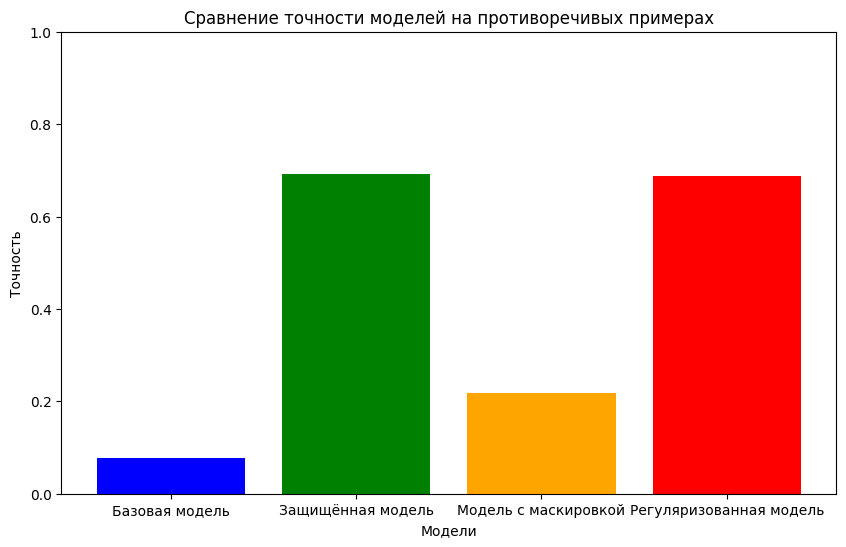

In [10]:
import matplotlib.pyplot as plt

# Данные для графика
models = ['Базовая модель', 'Защищённая модель', 'Модель с маскировкой', 'Регуляризованная модель']
accuracies = [
    base_model.evaluate(test_adversarial_images, test_labels[:3000])[1],  # Точность базовой модели
    protected_model.evaluate(test_adversarial_images, test_labels[:3000])[1],  # Точность защищённой модели
    masked_model.evaluate(test_adversarial_images, test_labels[:3000])[1],  # Точность модели с маскировкой
    regularized_model.evaluate(test_adversarial_images, test_labels[:3000])[1]  # Точность регуляризованной модели
]

# Построение графика
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Модели')
plt.ylabel('Точность')
plt.title('Сравнение точности моделей на противоречивых примерах')
plt.ylim(0, 1.0)
plt.show()

## Таблица с результатами оценки моделей:

In [11]:
from tabulate import tabulate

# Данные для таблицы
table = [
    ["Модель", "Точность", "Потери"],
    ["Базовая модель", base_model.evaluate(test_adversarial_images, test_labels[:3000])[1], base_model.evaluate(test_adversarial_images, test_labels[:3000])[0]],
    ["Защищённая модель", protected_model.evaluate(test_adversarial_images, test_labels[:3000])[1], protected_model.evaluate(test_adversarial_images, test_labels[:3000])[0]],
    ["Модель с маскировкой", masked_model.evaluate(test_adversarial_images, test_labels[:3000])[1], masked_model.evaluate(test_adversarial_images, test_labels[:3000])[0]],
    ["Регуляризованная модель", regularized_model.evaluate(test_adversarial_images, test_labels[:3000])[1], regularized_model.evaluate(test_adversarial_images, test_labels[:3000])[0]]
]

# Вывод таблицы
print(tabulate(table, headers="firstrow", tablefmt="pretty"))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0730 - loss: 6.3795
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0730 - loss: 6.3795
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6976 - loss: 0.9389
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6976 - loss: 0.9389
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2205 - loss: 4.4327
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2205 - loss: 4.4327
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6983 - loss: 1.0130
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6983 - loss: 1.0130
+-------------------------+---------------------+--------------------+
|         Модель          |      Точность       |       Потери       |
+-------------------------+---------------------+--------------------+
|     Базовая модель      | 0.07699999958276749 | 6.4156341552734375 |
|    Защищённая модель    | 0.6919999718666077  | 0.9657512307167053 |
|  Модель с маскировкой   | 0.21699999272823334 | 4.491795539

## График потерь моделей на противоречивых примерах:

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0730 - loss: 6.3795
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6976 - loss: 0.9389
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2205 - loss: 4.4327
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6983 - loss: 1.0130


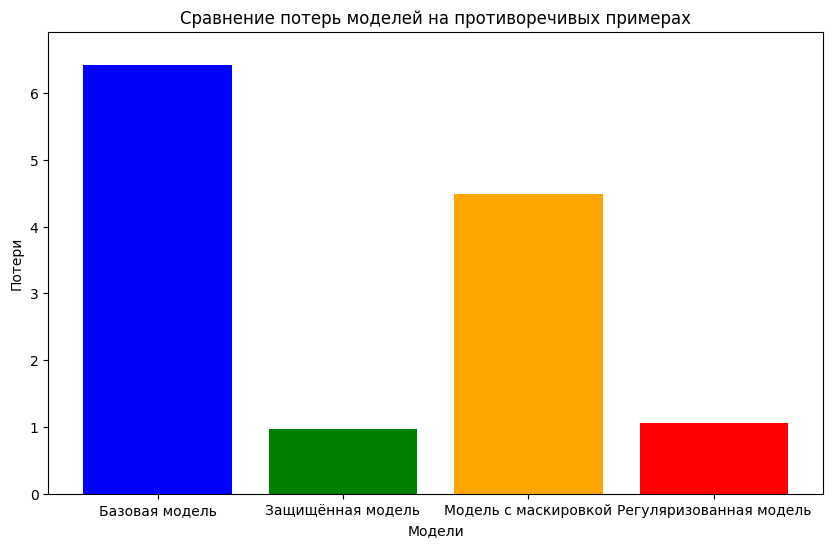

In [12]:
# Данные для графика
losses = [
    base_model.evaluate(test_adversarial_images, test_labels[:3000])[0],  # Потери базовой модели
    protected_model.evaluate(test_adversarial_images, test_labels[:3000])[0],  # Потери защищённой модели
    masked_model.evaluate(test_adversarial_images, test_labels[:3000])[0],  # Потери модели с маскировкой
    regularized_model.evaluate(test_adversarial_images, test_labels[:3000])[0]  # Потери регуляризованной модели
]

# Построение графика
plt.figure(figsize=(10, 6))
plt.bar(models, losses, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Модели')
plt.ylabel('Потери')
plt.title('Сравнение потерь моделей на противоречивых примерах')
plt.ylim(0, max(losses) + 0.5)
plt.show()

## Визуализация противоречивых примеров:

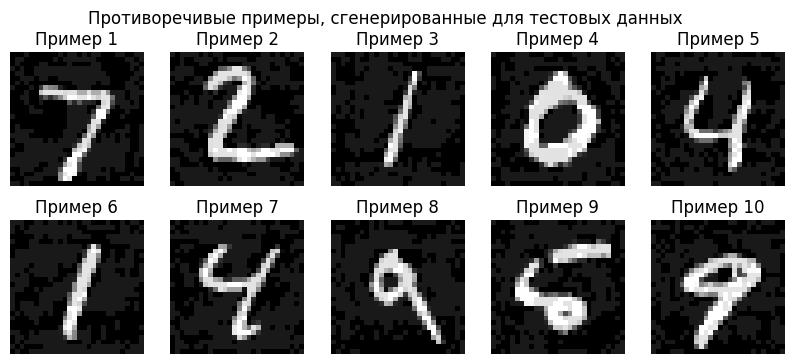

In [13]:
# Визуализация первых 10 противоречивых примеров
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_adversarial_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Пример {i+1}')
    plt.axis('off')
plt.suptitle('Противоречивые примеры, сгенерированные для тестовых данных')
plt.show()

График точности: Наглядно показывает, какая модель лучше справляется с противоречивыми примерами.

Таблица: Содержит точные численные значения точности и потерь для каждой модели.

График потерь: Показывает, насколько сильно модели ошибаются на противоречивых данных.

Визуализация примеров: Позволяет оценить качество сгенерированных противоречивых примеров.